In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as torchfunc
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 16472157.39it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 304174.79it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5504281.60it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4430093.76it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data),len(validation_data),len(test_data))
print(training_data[0][0].shape)

50000 10000 10000
torch.Size([1, 28, 28])


In [9]:
class CNNModel(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(64 * 7 * 7, num_classes)
        self.gradients = None
        self.feature_maps = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.pool(torchfunc.relu(self.conv1(x)))
        x = self.pool(torchfunc.relu(self.conv2(x)))
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        self.feature_maps = x
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self):
        return self.feature_maps

In [7]:
model = CNNModel()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.19
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


In [16]:
def plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(cost_hist, label='Training cost')
    ax1.plot(cost_hist_test, label='Testing cost')
    ax1.legend()
    ax1.grid()
    ax2.plot(acc_hist, label='Training accuracy')
    ax2.plot(acc_hist_test, label='Test accuracy')
    ax2.legend()
    ax2.grid()

In [24]:
def generate_gradcam_heatmap(model, feature_maps, gradients):
    # Pools gradients across channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weights channels by spec. gradients
    for i in range(feature_maps.shape[1]):
        feature_maps[:, i, :, :] *= pooled_gradients[i]

    # Average feature maps
    heatmap = torch.mean(feature_maps, dim=1).squeeze()

    heatmap = torchfunc.relu(heatmap)

    heatmap /= torch.max(heatmap)
    return heatmap

In [25]:
def visualize_gradcam(img, heatmap):
    plt.figure(figsize=(10, 5))

    # Original Image
    ax = plt.subplot(1, 2, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Heatmap overlay
    ax = plt.subplot(1, 2, 2)
    plt.imshow(img.squeeze(), cmap='gray')
    heatmap = heatmap.detach()
    plt.imshow(heatmap.numpy(), cmap='jet', alpha=0.5)  # alpha for transparency
    plt.title("GradCAM Heatmap Overlay")
    plt.axis('off')

    plt.show()


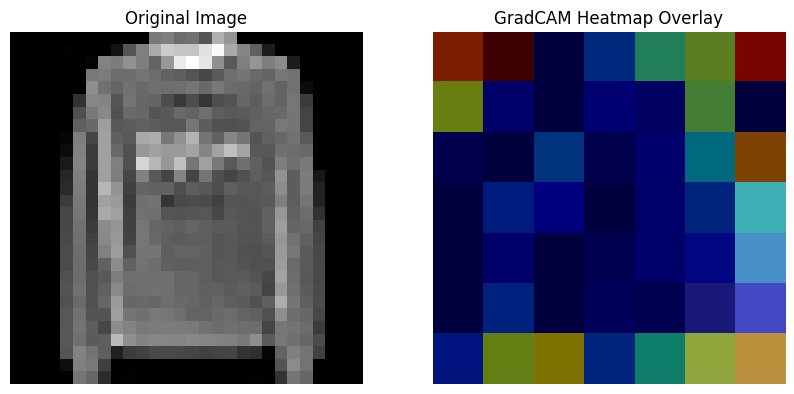

In [26]:
# Initial Test
dataiter = iter(DataLoader(training_data, batch_size=1, shuffle=True))
images, labels = next(dataiter)

outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

class_idx = predicted.item()

model.zero_grad()
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
loss.backward()

grads = model.get_activations_gradient()
fmaps = model.get_activations()
heatmap = generate_gradcam_heatmap(model, fmaps, grads)

visualize_gradcam(images[0], heatmap)

In [17]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()

    for epoch in range(nepochs):

        ### YOUR CODE HERE ###
        model.train()
        train_total = 0
        count_train = 0
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
            train_total += Y.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count_train += 1

        if scheduler:
            scheduler.step()

        cost /= count_train
        acc = acc / train_total

        cost_test, test_correct = 0, 0
        count_test = 0
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                loss = cost_ce(pred, Y)

                cost_test += loss.item()
                test_correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
                count_test += 1

        cost_test /= count_test
        acc_test = test_correct / len(test_loader.dataset)

        print(f"Epoch {epoch}: Train Loss: {cost:.4f}, Train Acc: {acc:.4f}, Test Loss: {cost_test:.4f}, Test Acc: {acc_test:.4f}")

        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

Epoch 0: Train Loss: 0.4227, Train Acc: 0.8485, Test Loss: 0.3677, Test Acc: 0.8708
Epoch 1: Train Loss: 0.3098, Train Acc: 0.8898, Test Loss: 0.3009, Test Acc: 0.8890
Epoch 2: Train Loss: 0.2838, Train Acc: 0.8965, Test Loss: 0.3225, Test Acc: 0.8824
Epoch 3: Train Loss: 0.2750, Train Acc: 0.8987, Test Loss: 0.2823, Test Acc: 0.8987
Epoch 4: Train Loss: 0.2652, Train Acc: 0.9026, Test Loss: 0.2831, Test Acc: 0.9032
Epoch 5: Train Loss: 0.2577, Train Acc: 0.9057, Test Loss: 0.3022, Test Acc: 0.8949
Epoch 6: Train Loss: 0.2549, Train Acc: 0.9074, Test Loss: 0.3265, Test Acc: 0.8898
Epoch 7: Train Loss: 0.2534, Train Acc: 0.9074, Test Loss: 0.3104, Test Acc: 0.8869
Epoch 8: Train Loss: 0.2438, Train Acc: 0.9100, Test Loss: 0.3245, Test Acc: 0.8932
Epoch 9: Train Loss: 0.2413, Train Acc: 0.9115, Test Loss: 0.3279, Test Acc: 0.8845


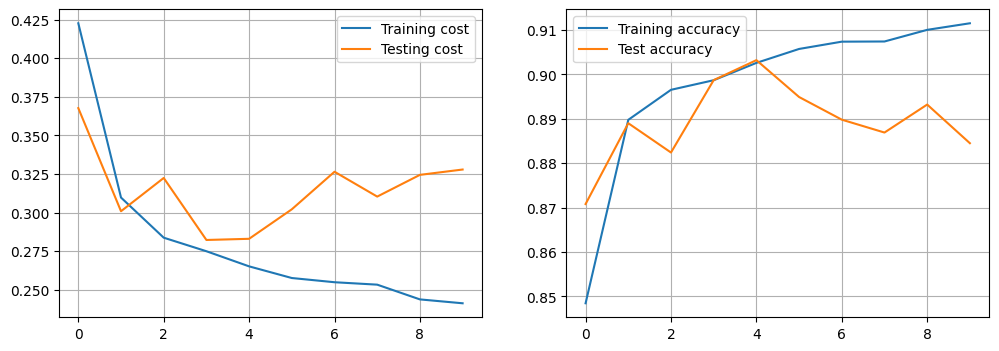

In [22]:
from torch import optim

batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = CNNModel()

learning_rate = 0.01
nepochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)

plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test)

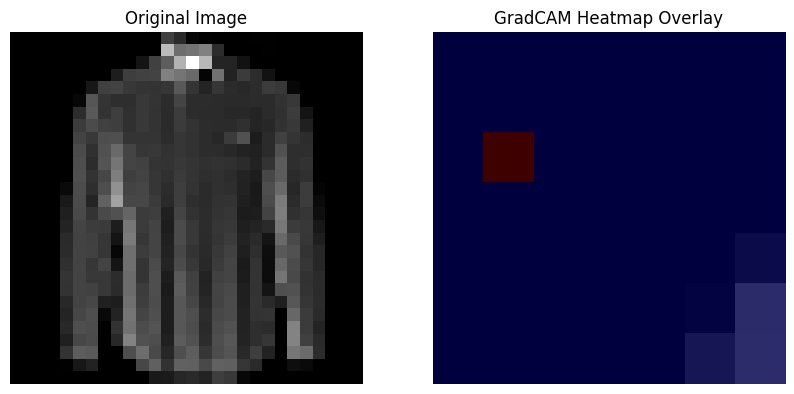

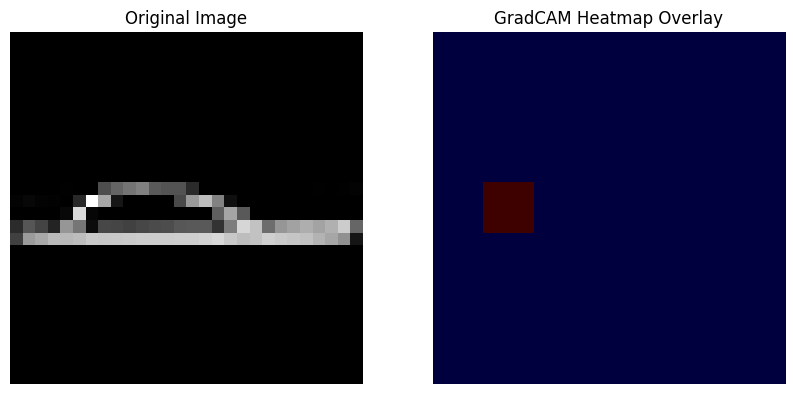

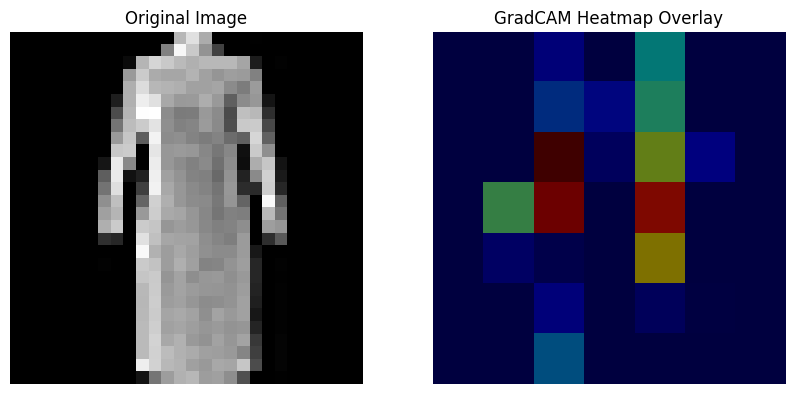

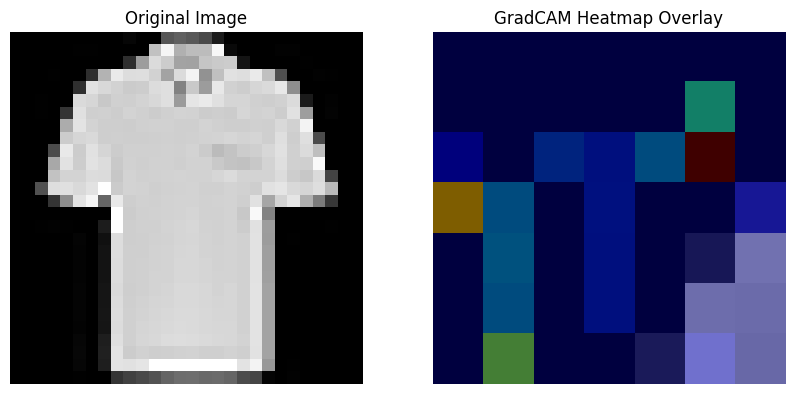

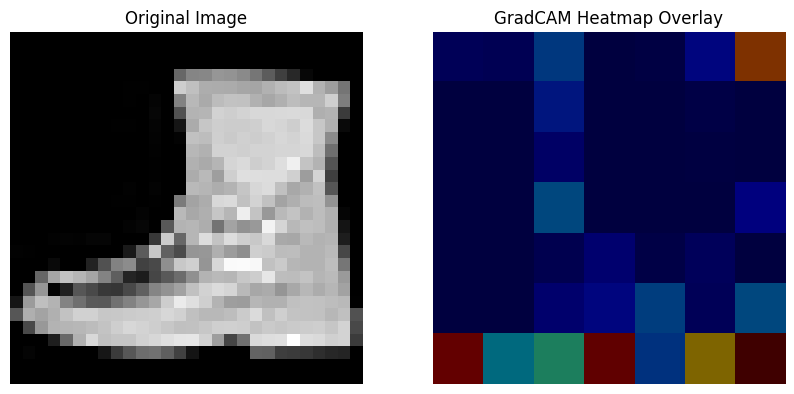

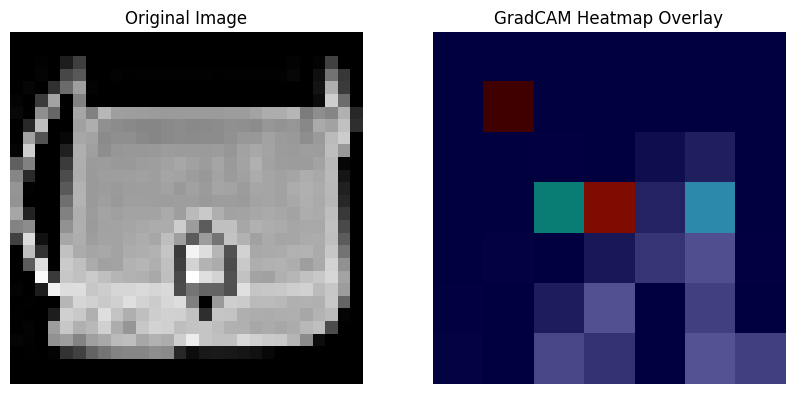

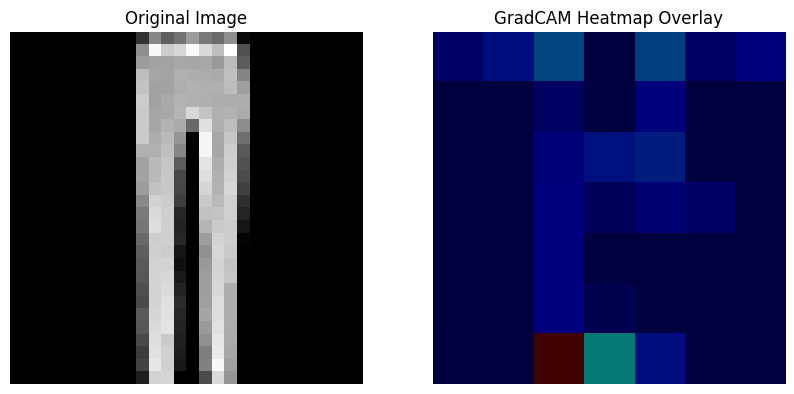

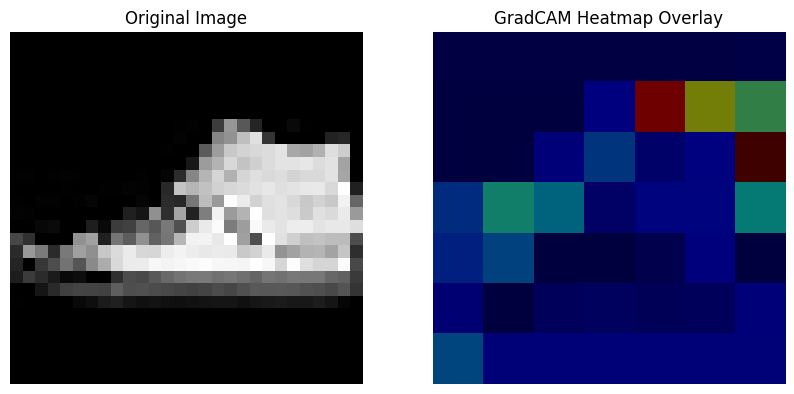

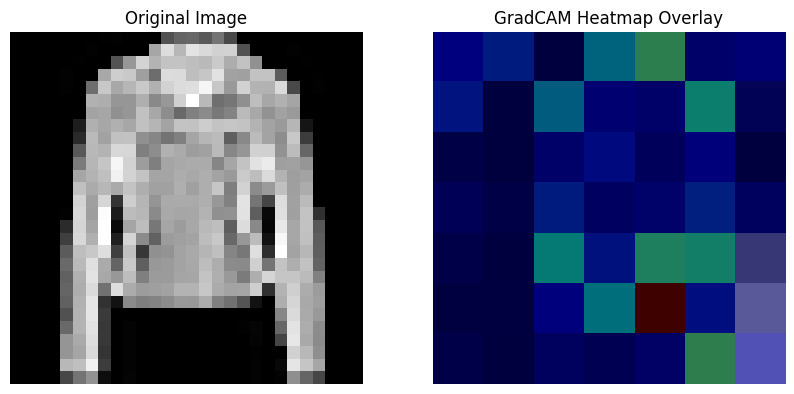

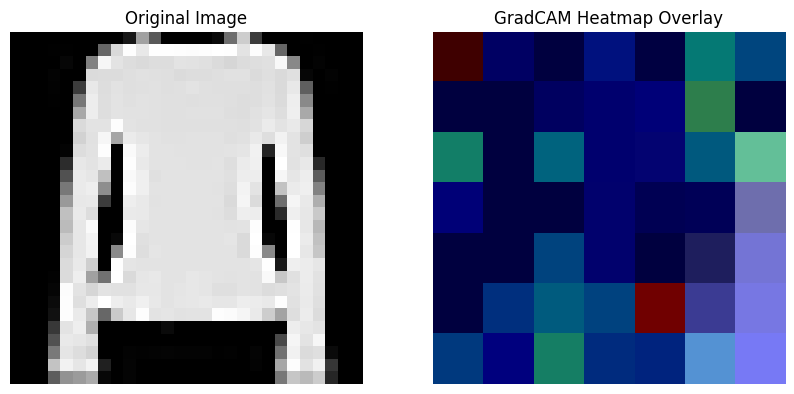

In [29]:
def select_samples_per_class(dataset):
    sample_images = {}
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    for image, label in data_loader:
        label = label.item()
        if label not in sample_images:
            sample_images[label] = image
    return sample_images

sample_images = select_samples_per_class(training_data)

for label, image in sample_images.items():
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    class_idx = predicted.item()

    model.zero_grad()
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(outputs, torch.tensor([label]))
    loss.backward()
    grads = model.get_activations_gradient()
    fmaps = model.get_activations()
    heatmap = generate_gradcam_heatmap(model, fmaps, grads)

    visualize_gradcam(image[0], heatmap)